# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sliding_window import SlidingWindow

# Globals

In [2]:
df = pd.read_csv('full_data.gz', compression='gzip')
df = df.drop(['Unnamed: 0'], axis=1).set_index('time')

In [3]:
num_experiments = 16
num_participants = 24
exclude = 10
analytic_functions_list = ['mean', 'sum', 'median', 'min', 'max', 'std']
labels_dict = {'wlk': 0, 'sit': 1, "std": 2, "ups": 3, "jog": 4, "dws": 5}

# Helper Functions

In [4]:
def data_allocation(df):
    # Define X,Y
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = df.drop(["action"], axis=1), df["action"]
    y = y.replace(labels_dict)
    
    # Divide to training, validation and test set 70%, 10%, 20%
    num_training = int(df.shape[0] * 0.7)
    num_validation = int(df.shape[0] * 0.1)
    X_train, y_train = X[:num_training], y[:num_training]
    X_vald, y_vald = X[num_training:num_training + num_validation], y[num_training:num_training + num_validation]
    X_test, y_test = X[num_training + num_validation:], y[num_training + num_validation:]
    
    return X_train, y_train, X_vald, y_vald, X_test, y_test

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

def create_classes(labels_dict):
    classes_indexs = labels_dict.items()
    classes_indexs = sorted(classes_indexs, key=lambda x: x[1])
    classes_names = [label for label, index in classes_indexs]
    return classes_names

def evaluate_results(y_true, y_pred, classes):
        print("---- Printing classification report ----")
        print(classification_report(y_true, y_pred, target_names=classes))
        
        accuracy = sum([1 for i in range(len(y_true)) if y_true.tolist()[i] == y_pred[i]]) * 1.0
        accuracy /= len(y_true)
        return accuracy

# Model Evaluation

## Prepare Dataframe to Classify

In [6]:
window = SlidingWindow(df, 10, num_experiments, num_participants, exclude, analytic_functions_list)
sld_df = window.df
X_train, y_train, X_vald, y_vald, X_test, y_test = data_allocation(sld_df)
classes_names = create_classes(labels_dict)

## Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   33.6s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   54.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

### Evaluate Results

In [8]:
prediction = rf.predict(X_vald)
evaluate_results(y_vald, prediction, classes_names)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.97      0.99      0.98     34608
        sit       1.00      1.00      1.00     33642
        std       1.00      1.00      1.00     30438
        ups       0.95      0.94      0.95     15572
        jog       0.99      0.98      0.98     13487
        dws       0.97      0.92      0.95     13179

avg / total       0.98      0.98      0.98    140926



0.9817989583185501

In [9]:
prediction_test = rf.predict(X_test)
evaluate_results(y_test, prediction_test, classes_names)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.97      0.99      0.98     68728
        sit       1.00      1.00      1.00     68011
        std       1.00      1.00      1.00     61353
        ups       0.96      0.94      0.95     31229
        jog       0.99      0.98      0.98     26476
        dws       0.97      0.93      0.95     26057

avg / total       0.98      0.98      0.98    281854



0.9826293045335528

### Export to CoreML

In [10]:
import coremltools
core_model = coremltools.converters.sklearn.convert(rf)
core_model.save('randomForest.mlmodel')

## Logistic Regression Classifier

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', verbose=1, max_iter=300)
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)

### Evaluate Results

In [15]:
lr_prediction = lr.predict(X_vald)
evaluate_results(y_vald, lr_prediction, classes_names)

---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.61      0.82      0.70     34432
        sit       0.99      0.98      0.99     33699
        std       0.97      0.98      0.98     30559
        ups       0.59      0.45      0.51     15701
        jog       0.84      0.83      0.83     13344
        dws       0.52      0.21      0.30     13191

avg / total       0.79      0.80      0.78    140926



## Perform the same analysis over the history data set

In [ ]:
hist_df = pd.read_pickle("history_10_encoded.pkl")

In [ ]:
hist_df.head(5)

In [ ]:
hist_df = hist_df.sample(frac=1).reset_index(drop=True)
labels_dict = {'wlk': 0, 'sit': 1, "std": 2, "ups": 3, "jog": 4, "dws": 5}
X, y = hist_df.drop(["action"], axis=1), hist_df["action"]
y = y.replace(labels_dict)

In [ ]:
num_training = int(hist_df.shape[0] * 0.7)
num_validation = int(hist_df.shape[0] * 0.1)
X_train, y_train = X[:num_training], y[:num_training]
X_vald, y_vald = X[num_training:num_training + num_validation], y[num_training:num_training + num_validation]
X_test, y_test = X[num_training + num_validation:], y[num_training + num_validation:]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
hist_rf = RandomForestClassifier(n_jobs=-1, verbose=1)
hist_rf.fit(X_train, y_train)

In [ ]:
prediction = hist_rf.predict(X_vald)
classes_names = create_classes(labels_dict)
evaluate_results(y_vald, prediction, classes_names)

In [ ]:
prediction_test = hist_rf.predict(X_test)
evaluate_results(y_test, prediction_test, classes_names)

Try also here linear model

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', verbose=1, max_iter=300)
lr.fit(X_train, y_train)

In [ ]:
lr_prediction = lr.predict(X_vald)
classes_names = create_classes(labels_dict)
evaluate_results(y_vald, lr_prediction, classes_names)

# Window Size Performance
### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, verbose=1)
size_start, size_end, jump = 2, 10, 1

In [73]:
accuracies = []
sizes = [i for i in range(size_start, size_end, jump)]

In [74]:
for size in sizes:
    window = SlidingWindow(df, size, num_experiments, num_participants, exclude, analytic_functions_list)
    sld_df = window.df
    X_train, y_train, X_vald, y_vald, X_test, y_test = data_allocation(sld_df)
    rf.fit(X_train, y_train)
    
    prediction = rf.predict(X_vald)
    acc = evaluate_results(y_vald, prediction, classes_names)
    accuracies.append(acc)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.9s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.85      0.95      0.89     34345
        sit       1.00      1.00      1.00     33760
        std       0.99      0.99      0.99     30819
        ups       0.82      0.75      0.79     15730
        jog       0.90      0.89      0.89     13343
        dws       0.82      0.67      0.74     13217

avg / total       0.92      0.92      0.91    141214



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.0s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.88      0.96      0.92     34399
        sit       1.00      1.00      1.00     33851
        std       0.99      0.99      0.99     30588
        ups       0.85      0.79      0.82     15629
        jog       0.93      0.92      0.92     13514
        dws       0.86      0.73      0.79     13197

avg / total       0.93      0.93      0.93    141178



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.0s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.91      0.97      0.94     34665
        sit       1.00      1.00      1.00     34039
        std       1.00      0.99      1.00     30365
        ups       0.89      0.84      0.86     15589
        jog       0.95      0.95      0.95     13326
        dws       0.90      0.79      0.84     13158

avg / total       0.95      0.95      0.95    141142



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   38.9s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.93      0.98      0.95     34235
        sit       1.00      1.00      1.00     34185
        std       1.00      1.00      1.00     30425
        ups       0.91      0.87      0.89     15873
        jog       0.96      0.96      0.96     13332
        dws       0.91      0.83      0.87     13056

avg / total       0.96      0.96      0.96    141106



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   34.6s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.94      0.98      0.96     34373
        sit       1.00      1.00      1.00     33632
        std       1.00      1.00      1.00     30648
        ups       0.92      0.89      0.91     15766
        jog       0.97      0.96      0.97     13438
        dws       0.93      0.86      0.89     13213

avg / total       0.97      0.97      0.97    141070



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   37.1s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   58.9s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.95      0.98      0.97     34611
        sit       1.00      1.00      1.00     33776
        std       1.00      1.00      1.00     30555
        ups       0.94      0.91      0.92     15842
        jog       0.97      0.97      0.97     13266
        dws       0.94      0.89      0.91     12984

avg / total       0.97      0.97      0.97    141034



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   37.6s remaining:   25.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.5s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.95      0.99      0.97     34282
        sit       1.00      1.00      1.00     33776
        std       1.00      1.00      1.00     30458
        ups       0.94      0.92      0.93     15603
        jog       0.98      0.98      0.98     13744
        dws       0.95      0.90      0.92     13135

avg / total       0.98      0.98      0.98    140998



[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   37.4s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.4s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


---- Printing classification report ----
             precision    recall  f1-score   support

        wlk       0.96      0.99      0.97     34431
        sit       1.00      1.00      1.00     33991
        std       1.00      1.00      1.00     30385
        ups       0.95      0.93      0.94     15645
        jog       0.98      0.98      0.98     13474
        dws       0.96      0.92      0.94     13036

avg / total       0.98      0.98      0.98    140962



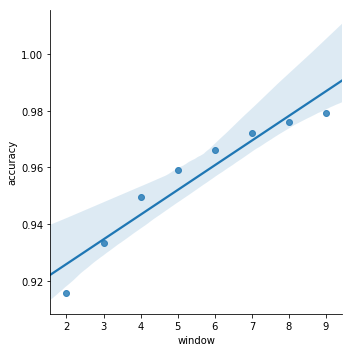

In [76]:
plot_data = [{"window": sizes[i], "accuracy": accuracies[i]} for i in range(len(sizes))]
plot_df = pd.DataFrame(plot_data)
sns.lmplot(x="window", y="accuracy", data=plot_df)

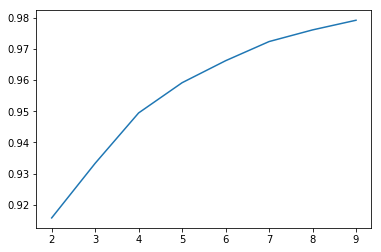

In [80]:
plt.plot(sizes, accuracies, )

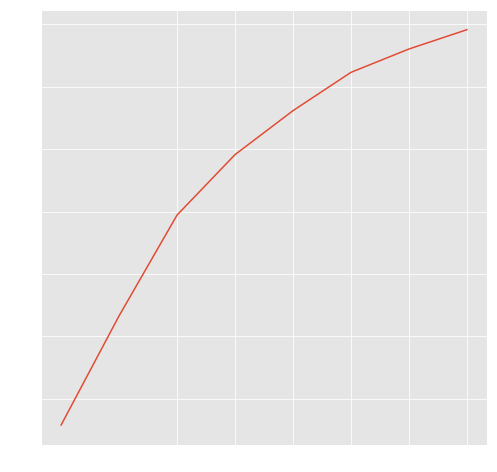

In [116]:
fig = plt.figure(figsize=(8,8))
plt.subplot()
plt.style.use("ggplot")
plt.xticks(sizes)
plt.plot(accuracies)
plt.gca().tick_params(colors='w', labelsize='large')

plt.savefig("window_accuracy_plot.png", transparent=True)